Preprocessing planet imagery for median mosaic

1. mask clouds
2. assign nodata for partial overlap scenes within bounds of supercell
3. median for each band and composite

In [6]:
from shapely.geometry import Polygon
import pyproj
import numpy as np
import geopandas as gpd
import rasterio as rio
from rasterio import mask
import rasterstats as rstats
import skimage as ski
import matplotlib.pyplot as plt
import glob
import os
from rasterio.plot import reshape_as_raster, reshape_as_image
os.chdir('../')
from filter_callable import cloud_shadow_stats
sr_pattern = "/home/rave/cloud-free-planet/notebooks/jan_april_2018_100ovp_50maxcloud/*SR*.tif"
img_paths = glob.glob(sr_pattern)
udm_pattern = "/home/rave/cloud-free-planet/notebooks/jan_april_2018_100ovp_50maxcloud/*udm*.tif"
udm_paths = glob.glob(udm_pattern)

img_paths = sorted(img_paths)

udm_paths = sorted(udm_paths)

def filter_date(lst, month_int, month_digit1, month_digit2):
    """Takes a list of udms or images and returns filtered by month lists
    example
    imgs_may = filter_date(img_paths, '05', 12, 14)
    udms_may = filter_date(udm_paths, '05', 12, 14)"""
    return [i for i in lst if os.path.basename(i)[month_digit1:month_digit2] == month_int]


def test_udm_mask(image_path, udm_path):
    """
    Masks a planet image by it's udm
    """

    img = rio.open(image_path)
    img_meta = img.profile
    img_array = np.array([img.read(1), img.read(2), img.read(3), img.read(4)])
    mask = rio.open(udm_path).read(1)[..., :] == 0 # 0 is the value in the udm that corresponds to good data
    masked = np.where(mask,img_array, 0)
    return np.swapaxes(np.swapaxes(masked, 0, 2),0, 1)


def test_custom_mask(image_path):
    """
    Masks a custom cloud mask from filter_callable
    """

    img = rio.open(image_path)
    img_meta = img.profile
    cloud_arr, shadow_arr = cloud_shadow_stats(image_path)
    cloud_arr = np.logical_not(cloud_arr.astype(bool))
    shadow_arr = np.logical_not(shadow_arr.astype(bool))
    masked = np.where(cloud_arr,img.read(), False)
    masked = np.where(shadow_arr,masked, False)
    return np.swapaxes(np.swapaxes(masked, 0, 2),0, 1)

from skimage import exposure

def percentile_rescale(arr, plow=1, phigh=99):
    '''
    Rescales and applies other exposure functions to improve image vis. 
    http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.rescale_intensity
    '''
    rescaled_arr = np.zeros_like(arr)
    for i in range(0,arr.shape[-1]):
        val_range = (np.percentile(arr[:,:,i], plow), np.percentile(arr[:,:,i], phigh))
        rescaled_channel = exposure.rescale_intensity(arr[:,:,i], val_range)
        rescaled_arr[:,:,i] = rescaled_channel
#     rescaled_arr= exposure.adjust_gamma(rescaled_arr, gamma=1) #adjust from 1 either way
#     rescaled_arr= exposure.adjust_sigmoid(rescaled_arr, cutoff=.50) #adjust from .5 either way 
    return rescaled_arr
def normalize(arr):
    ''' Function to normalize an input array to 0-1 '''
    arr_max = arr.max()
    return arr / arr_max

def reorder_to_brg(image):
    '''reorders wv2 bands ordered like RGBNRGN for off/onseason
    to blue, red, green for imshow
    '''
    blue = normalize(image[:,:,2])
    green = normalize(image[:,:,1])
    red = normalize(image[:,:,0])
    nir = normalize(image[:,:,3])
    return np.stack([blue, red, green], axis=-1)

def is_even(x):
    if x%2 == 1:
        return False
    else:
        return True
def is_div_by(x, y):
    if x%y == 0:
        return True
    else:
        return False
def even_only(iter):
    return [x for x in iter if is_even(x)]
def odds_only(iter):
    return [x for x in iter if not is_even(x)]
def by_3_only(iter):
    return [x for x in iter if is_div_by(x, 3)]
def by_3_no_odd_only(iter):
    return [x for x in iter if is_div_by(x, 3) and is_even(x)]
def even_no_3_only(iter):
    return [x for x in iter if not is_div_by(x, 3) and is_even(x)]
def odd_no_3_only(iter):
    return [x for x in iter if not is_div_by(x, 3) and not is_even(x)]

In [27]:
imgs_april = filter_date(img_paths, '04', 4,6)
udms_april = filter_date(udm_paths, '04', 4,6)
imgs_march = filter_date(img_paths, '03', 4,6)
udms_march = filter_date(udm_paths, '03', 4,6)
imgs_feb = filter_date(img_paths, '02', 4,6)
udms_feb = filter_date(udm_paths, '02', 4,6)
imgs_jan = filter_date(img_paths, '01', 4,6)
udms_jan = filter_date(udm_paths, '01', 4,6)

In [40]:
sr_pattern = "/home/rave/cloud-free-planet/notebooks/small_supercell_and_full_scenes_May-September/clipped/*SR*.tif"
img_paths = glob.glob(sr_pattern)
udm_pattern = "/home/rave/cloud-free-planet/notebooks/small_supercell_and_full_scenes_May-September/clipped/udms/*udm.tif"
udm_paths = glob.glob(udm_pattern)

img_paths = sorted(img_paths)

udm_paths = sorted(udm_paths)

imgs_may = filter_date(img_paths, '05', 12,14)
udms_may = filter_date(udm_paths, '05', 12,14)

The below block plots all the images and masks for a month, needs to be functionalized

In [ ]:
fig=plt.figure(figsize=(20, 350))
columns = 3
rows = 78
plot_indices = list(range(1,78))
path_indices = list(range(1, 26))
for i, even, odd, by_3 in zip(path_indices, even_no_3_only(plot_indices), odd_no_3_only(plot_indices), by_3_only(plot_indices)):
    udm_masked = test_udm_mask(imgs_may[i], udms_may[i])
    custom_masked = test_custom_mask(imgs_may[i])
    udm_masked = normalize(udm_masked)
    custom_masked = normalize(custom_masked)
    udm_masked_rgb = reorder_to_brg(udm_masked)
    custom_masked_rgb = reorder_to_brg(custom_masked)
    fig.add_subplot(rows, columns, even)
    plt.imshow(percentile_rescale(udm_masked_rgb, plow=.5, phigh=99.5))
    plt.title("UDM")
    fig.add_subplot(rows, columns, odd)
    plt.imshow(percentile_rescale(custom_masked_rgb, plow=.5, phigh=99.5))
    plt.title("Custom Mask")
    fig.add_subplot(rows, columns, by_3)
    img = ski.io.imread(imgs_may[i])
    plt.imshow(img[:,:,0])
    plt.title("Blue Band No Mask")                     
plt.tight_layout()
plt.savefig("all_may_images.png", bbox_inches='tight')
plt.show()



In [43]:
def make_median_composite(imgs, udms):
    """Take slist of image arrays and udm arrays"""
    udm_mask_arrs = [test_udm_mask(img, udm).astype(float) for img,udm in zip(imgs, udms)]
    custom_mask_arrs = [test_custom_mask(img).astype(float) for img in imgs_may]
    for arr in udm_mask_arrs:
        arr[arr==0] = np.nan
    for arr in custom_mask_arrs:
        arr[arr==0] = np.nan
    udm_masked_med = np.nanmedian(udm_mask_arrs, axis=0)
    custom_masked_med = np.nanmedian(custom_mask_arrs, axis=0)
    return (udm_masked_med, custom_masked_med)

In [45]:
jan_composites = make_median_composite(imgs_jan, udms_jan)
feb_composites = make_median_composite(imgs_feb, udms_feb)
march_composites = make_median_composite(imgs_march, udms_march)
april_composites = make_median_composite(imgs_april, udms_april)

Percentage of scene that is cloudy: 0.013714417869601248 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.727415344884075 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.15486345327345963 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.0 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.0 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.014096016343207354 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.16158189912694895 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.44722184747624644 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.9324339429915007 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.13672788945207856 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.1566827914506524 Percentage of scene with shadows0.0
Percentage of scene th

Percentage of scene that is cloudy: 0.0 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.0 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.7773353633858192 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.8479773353633858 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.40634455643995604 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.72664443887679 Percentage of scene with shadows0.0


In [47]:
may_composites = make_median_composite(imgs_may, udms_may)

Percentage of scene that is cloudy: 0.013714417869601248 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.727415344884075 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.15486345327345963 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.0 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.0 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.014096016343207354 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.16158189912694895 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.44722184747624644 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.9324339429915007 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.13672788945207856 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.1566827914506524 Percentage of scene with shadows0.0
Percentage of scene th

In [49]:
imgs_may_april = imgs_may +imgs_april
udms_may_april = udms_may + udms_april

may_april_composites = make_median_composite(imgs_may_april, udms_may_april)

Percentage of scene that is cloudy: 0.013714417869601248 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.727415344884075 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.15486345327345963 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.0 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.0 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.014096016343207354 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.16158189912694895 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.44722184747624644 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.9324339429915007 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.13672788945207856 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.1566827914506524 Percentage of scene with shadows0.0
Percentage of scene th

/home/rave/anaconda3/envs/geo/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [57]:
imgs_may_jan = imgs_may +imgs_april + imgs_march +imgs_feb +imgs_jan
udms_may_jan = udms_may + udms_april + imgs_march +imgs_feb +imgs_jan

may_jan_composites = make_median_composite(imgs_may_jan, udms_may_jan)

Percentage of scene that is cloudy: 0.013714417869601248 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.727415344884075 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.15486345327345963 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.0 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.0 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.014096016343207354 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.16158189912694895 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.44722184747624644 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.9324339429915007 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.13672788945207856 Percentage of scene with shadows0.0
Percentage of scene that is cloudy: 0.1566827914506524 Percentage of scene with shadows0.0
Percentage of scene th

/home/rave/anaconda3/envs/geo/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


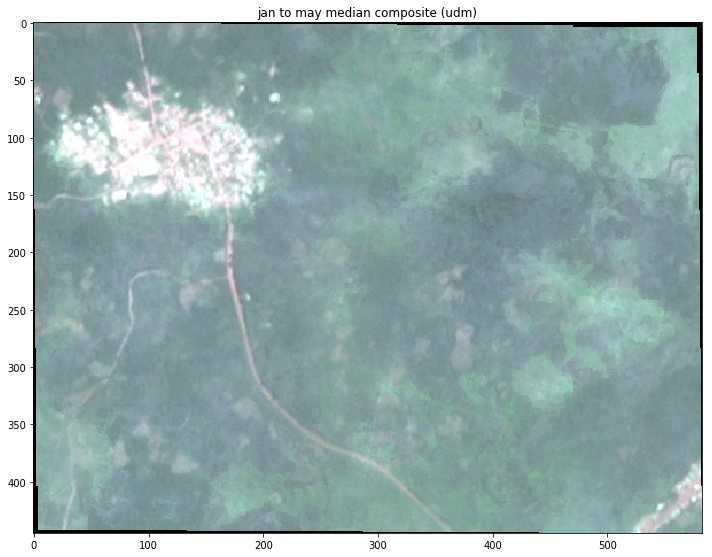

In [59]:
plt.figure(figsize=(10,10))
ski.io.imshow(
    percentile_rescale(
        reorder_to_brg(
            normalize(
                np.nan_to_num(may_jan_composites[0])
            ))))
plt.title("jan to may median composite (udm)")
plt.savefig('udm_composite_may_jan.png')

In [ ]:
plt.figure(figsize=(10,10))
ski.io.imshow(
    percentile_rescale(
        reorder_to_brg(
            normalize(
                np.nan_to_num(custom_masked_med)
            ))))
plt.title("custom may composite")
plt.savefig('custom_composite_may.png')

Below is older code for saving out the masked images when I was using GRASS GIS to do the median compositing. Solved median compositing in numpy now above

In [ ]:

def custom_mask(image_path):
    """
    Masks a custom cloud mask from filter_callable
    """

    img = rio.open(image_path)
    img_meta = img.profile
    cloud_arr, shadow_arr = cloud_shadow_stats(image_path)
    masked = np.where(cloud_arr,img.read(), 0)
    # need to fix this shdow mask #masked = np.where(shadow_arr,masked, 0)
    with rio.open(image_path[0:-12]+'custom_masked.tif', 'w', **img_meta) as dst:
        dst.write(masked) # when mask is true yield img, otherwise yield nan



In [ ]:
list(map(custom_mask, img_paths))

In [ ]:
def check_udm_and_mask(img_path):
    
    def udm_mask(image_path, udm_path):
        """
        Masks a planet image by it's udm
        """
    
        img = rio.open(image_path)
        img_meta = img.profile
        img_array = np.array([img.read(1), img.read(2), img.read(3), img.read(4)])
        mask = rio.open(udm_path).read(1)[..., :] == 0 # 0 is the value in the udm that corresponds to good data
        masked = np.where(mask,img_array, 0)
        with rio.open(img_path[0:-12]+'masked.tif', 'w', **img_meta) as dst:
            dst.write(masked) # when mask is true yield img, otherwise yield nan
        
    if os.path.isfile(img_path) and os.path.isfile(img_path[0:-12]+'_DN_udm_clip.tif'):
        udm_mask(img_path, img_path[0:-12]+'_DN_udm_clip.tif')
    else:
        pass
    
map(check_udm_and_mask, img_paths)

In [ ]:
masked_pattern = "/home/rave/cloud-free-planet/mosaic-tests/*custom*.tif"
masked_paths = glob.glob(masked_pattern)

In [ ]:
import functools
def save_single_bands(t):
    """
    Takes a band index and a path. Saves the
    specified band of each tif and names it by the band index. 
    """
    (band_index, path) = t
    img = rio.open(path)
    meta = img.profile
    meta.update(count=1) # update since we are writing a single band
    arr = img.read(band_index)
    dst_path = os.path.join(os.path.dirname(path),"Band_"+str(band_index)+"_"+os.path.basename(path))
    with rio.open(dst_path, 'w', **meta) as dst:
        dst.write(arr, 1)


In [ ]:
for i in [1, 2, 3, 4]:
    list(map(save_single_bands, [(i, x) for x in masked_paths]))

The above functions take raw analytic_sr that has been clipped and the udm masks and masks the data, then saves each band seperately out. Median compositing is done in GRASS GIS, because couldn't figure out how to median composite partially overlapping arrays wtih rasterio and numpy

# Code for creating Coarse Africa Grid in Decimal Degrees, WGS84 Datum

Below is the coarse layout defined in geopyspark to merge model outputs. Each tile is .0512 degrees by .0512 degrees. need to make a shapely multi line string or polygon bject that can be used to save out tiles as geojsons (only if they intersect an aoi) so that we can use each tile geojson with porder

coarse_layout = gps.LayoutDefinition(gps.Extent(-17.541, -34.845, 51.4766, 37.5518), gps.TileLayout(1348, 1414, 4096, 4096))

In [ ]:
def layout_to_geojson(extent=(-17.541, -34.845, 51.4766, 37.5518), stepsize=.0512, output_name="/dev/data/tile_grid.geojson"):
    """
    :param extent: (lonmin, latmin, lonmax, latmax) checked this by 
    looking at coarse layout in run_geopyspark
    
    :param stepsize: width and height of tile in degrees, checked 
    this by measuring extent of probability image tiles
    
    :returns: a geodataframe where each row is a tile polygon
    """
    
    (lonmin, latmin, lonmax, latmax) = extent
    cols = (lonmax - lonmin)/.0512
    rows = (latmax - latmin)/.0512
    # Top left corner of grid, where we start to build the gdf
    XleftOrigin = lonmin
    XrightOrigin = lonmin + stepsize
    YtopOrigin = latmax
    YbottomOrigin = latmax - stepsize
    polygons = []
    
    for i in range(int(cols)):
        
        Ytop = YtopOrigin
        Ybottom =YbottomOrigin
        for j in range(int(rows)):
            polygons.append(Polygon([(XleftOrigin, Ytop), (XrightOrigin, Ytop), (XrightOrigin, Ybottom), (XleftOrigin, Ybottom)])) 
            Ytop = Ytop - stepsize
            Ybottom = Ybottom - stepsize
        XleftOrigin = XleftOrigin + stepsize
        XrightOrigin = XrightOrigin + stepsize

    grid = gpd.GeoDataFrame({'geometry':polygons})
    grid.to_file(output_name, driver = "GeoJSON")
    
layout_to_geojson()

In [ ]:
aoi1_polygon = gpd.read_file("../cfg/aois/1.geojson")['geometry'][0]
grid_gdf = gpd.read_file("/dev/data/tile_grid.geojson")

aoi1_grid_geometries = grid_gdf.intersection(aoi1_polygon)
aoi1_grid_geometries= aoi1_grid_geometries[aoi1_grid_geometries.is_empty==False]

test_geom=aoi1_grid_geometries.iloc[6]

gpd.GeoSeries([test_geom]).to_file('test_tile.geojson', driver= "GeoJSON")

In [ ]:
gpd.GeoSeries([test_geom]).to_file('test_tile.geojson', driver= "GeoJSON")

ssh for idlist

In [ ]:
porder idlist --input "/home/ubuntu/planet/cloud-free-planet/notebooks/test_tile.geojson" --start "2018-07-01" --end "2018-07-31" --item "PSScene4Band" --asset "analytic_sr" --number 10000 --outfile "/home/ubuntu/planet/cloud-free-planet/notebooks/test_aoi1_id.csv" --cmin 0 --cmax 1 --overlap 0


ssh command for ordering

In [ ]:
porder order --name test-aoi1-month07 --idlist ~/planet/cloud-free-planet/notebooks/test_aoi1_id.txt --item PSScene4Band --asset analytic_sr --boundary test_tile.geojson --aws ~/planet/cloud-free-planet/notebooks/aws.yaml --op aws

In [ ]:
from subprocess import Popen, PIPE
p = Popen("porder",stdout=PIPE, stderr=PIPE)
stdout, stderr = p.communicate()

In [ ]:
stderr